In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import streak_cut as sc
import gradient_image as gi
import numpy as np
import matplotlib.pyplot as plt
from src import utils
import pandas as pd
import os
from tqdm import tqdm as tqdm
import astropy.io.fits as fits



In [ ]:
width = 100
height = 100
point1 = (99, 80)
point2 = (0,20)
img = gi.create_gradient_image_with_line(height, width, point1, point2)
cut = sc.cut_around_line(img, point1, point2, 32)
ax, fig = plt.subplots(1, 2)
fig[0].imshow(img, cmap='gray')
fig[1].imshow(cut, cmap='gray')
plt.show()



In [ ]:
streaks_csv = utils.read_streaks_csv()


In [ ]:
# Sort through r_SDSS.correlated_streaks.csv and add astred.cal.fits to the file name if it is needed

correlated_df = pd.read_csv('data/r_SDSS.correlated_streaks.csv')
for index, row in correlated_df.iterrows():
    path = utils.get_fits_path(row['file_name'], True)
    name = path.split('/')[-1]
    correlated_df.at[index, 'file_name'] = name
correlated_df.to_csv('data/r_SDSS.correlated_streaks_fixed.csv', index=False)



In [ ]:
# Aggregate all .streaks files into a single CSV file

# Define the root directory of the project
root_dir = os.path.join('/media/dofri/OBSERVATIONS/VST_BUFFER/')

# List to hold individual dataframes
dataframes = []

type_1 = ['#extension', 'start_x',     'start_y',    'end_x',     'end_y',      'start_ra',      'start_dec',     'end_ra',      'end_dec',      'mjd_start',     'mjd_end']
type_2 = ['extension', 'x_start[px]', 'y_start[px]','x_end[px]', 'y_end[px]',  'ra_start[deg]', 'dec_start[deg]','ra_end[deg]', 'dec_end[deg]', 'JD_start[UTC]', 'JD_end[UTC]']
column_mapping = dict(zip(type_1, type_2))


# Walk through the directory structure
for subdir, dirs, files in os.walk(root_dir):
    # Skip directories named 'L1_DETECTION'
    if 'L1_DETECTION' in subdir:
        continue
    
    for file in files:
        # Check if the file has the extension '.fits.streaks'
        if file.endswith('.fits.streaks'):
            file_path = os.path.join(subdir, file)
            
            # Read the .streaks file into a dataframe
            df = pd.read_csv(file_path)
            file_name = file[:-8]
            df.insert(0, 'file_name', file[:-8])
            # df.insert(1, 'file_path', subdir)
            # Remove the time_method column if it exists
            if ' time_method' in df.columns:
                df.drop(columns=[' time_method'], inplace=True)
            df.rename(columns=column_mapping, inplace=True)
            # Append the dataframe to the list
            dataframes.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)


# Save the combined dataframe to a single CSV file
combined_df.to_csv('combined_streaks.csv', index=False)

print(combined_df.columns)

print("All CSV files have been successfully concatenated into 'combined_streaks.csv'")

#count the number of rows with no nans or nulls or empty strings except for 'time_method'
print(combined_df.dropna().shape[0])
# Create histogram for each column
# for column in combined_df.columns:
#     if column in ['file_name', 'file_path']:
#         continue
#     combined_df[column].hist()
#     plt.title(column)
#     plt.show()

In [ ]:
# Compare and combine the aggregated streaks with the correlated streaks, using the data from the aggregated streaks as the primary data source.
# Now realizing that I only end up using the data from one source so a lot of this is redundant but oh well.

combined_df = pd.read_csv('combined_streaks.csv')
correlated_df = pd.read_csv('data/r_SDSS.correlated_streaks_fixed.csv')
match_columns = ['file_name', 'extension', 'ID']
merged_df = pd.merge(combined_df, correlated_df, on=match_columns, suffixes=('_df1', '_df2'), how='outer', indicator=True)
# Find differences between other columns
difference_columns = [col for col in combined_df.columns if col not in match_columns]
zipped_columns = []
for col in difference_columns:
    zipped_columns.append(f'{col}_df1')
    zipped_columns.append(f'{col}_df2')

# Include the matching columns at the start
final_columns_order = match_columns + zipped_columns
merged_df = merged_df[final_columns_order]
print(merged_df.columns)

merged_df.to_csv('comparison.csv', index=False)
print("Saved comparison to 'comparison.csv'")

def find_diff(col1, col2):
    return merged_df[ (merged_df[col1] != merged_df[col2]) 
                     & merged_df[col1].notna() 
                     & merged_df[col2].notna()][[col1, col2]]

columns_of_interest = ['x_start[px]', 'y_start[px]', 'x_end[px]', 'y_end[px]', 'ang_vel[deg/s]']

# for col in columns_of_interest:
#     diff = find_diff(f'{col}_df1', f'{col}_df2')
#     if not diff.empty:
#         print(f"Differences in column '{col}':")
#         print(diff)
#         
# Save the columns of interest to a new CSV file with file_name, extension and ID. Prioritize the first dataframe in the case of a difference
new_df = merged_df[['file_name', 'extension', 'ID']].copy()
print(merged_df.columns)
new_df.insert(3, 'x_start[px]', merged_df['x_start[px]_df2'])
new_df.insert(4, 'y_start[px]', merged_df['y_start[px]_df2'])
new_df.insert(5, 'x_end[px]', merged_df['x_end[px]_df2'])
new_df.insert(6, 'y_end[px]', merged_df['y_end[px]_df2'])
new_df.insert(7, 'ang_vel[deg/s]', merged_df['ang_vel[deg/s]_df2'])
# Throw away any rows with NaN values
new_df.dropna(inplace=True)
new_df.to_csv('good_data.csv', index=False)


# # Print differences between matching row
# 
# # Print differences between matching rows
# for col in difference_columns:
#     diff = merged_df[f'{col}_df1'] != merged_df[f'{col}_df2']
#     differing_rows = merged_df[diff]
#     if not differing_rows.empty:
#         print(f"Differences in column '{col}':")
#         print(differing_rows[[f'{col}_df1', f'{col}_df2', *match_columns]])
# 
# print("Comparison complete.")
# Math by file_name, extention and ID. Print differences in other columns


In [ ]:
good_data = pd.read_csv('good_data.csv') 

# pick 10 random rows
sample = good_data.sample(10)
for index, row in sample.iterrows():
    file_path = utils.get_fits_path(row['file_name'], True)
    with fits.open(file_path) as hdul:
        data = hdul[row['extension']].data
        start = (row['x_start[px]'], row['y_start[px]'])
        end = (row['x_end[px]'], row['y_end[px]'])
        cut = sc.cut_around_line(data, start, end, 32)[:,:]
        # # Display the cut along with a histogram of the cut
        # ax, fig = plt.subplots(1, 2)
        # fig[0].imshow(cut, cmap='gray')
        # # histogram in log scale
        # fig[1].hist(cut.flatten(), bins=256, log=True)
        plt.imshow(cut, cmap='gray', norm=utils.LogNorm())
        title = f"{row['file_name']} - {row['extension']} - {row['ID']}"
        plt.title(title)
        print(title)
        plt.show()
        

In [ ]:
# utils.show_streak_with_endpoints('OMEGA.2022-01-05T06:08:00.955.fits', 19, 1, True)
utils.show_streak_with_endpoints('OMEGA.2022-01-08T04:30:31.115.astred.cal.fits', 7, 6, True)

In [ ]:
good_data = pd.read_csv('good_data.csv')
# get first row
row = good_data.iloc[1]
bzero_counts = {}

for idx, row in good_data.iterrows():
    with fits.open(utils.get_fits_path(row['file_name'], True)) as hdul:
        # print the extension metadata
        # print(hdul[0].header)
        # hdul.info()
        # for i in range(1, len(hdul)):
        i = 1
        if hdul[i].header['BZERO'] in bzero_counts.keys():
            bzero_counts[hdul[i].header['BZERO']] += 1
        else:
            bzero_counts[hdul[i].header['BZERO']] = 1
        # if hdul[i].header['BSCALE'] != 1.0:
        #     print(row['file_name'] + " BSCALE[" + str(i) + "]: " + str(hdul[i].header['BSCALE']))
        # if hdul[i].header['BZERO'] != 32768:
        #     print(row['file_name'] + " BZERO[" + str(i) + "]: " + str(hdul[i].header['BZERO']))

print(bzero_counts)

In [ ]:
good_data = pd.read_csv('good_data.csv')
# get first row
row = good_data.iloc[1]
bzero_counts = {}

with fits.open(utils.get_fits_path(row['file_name'], True)) as hdul:
    print(hdul[1].data.shape)
    print(hdul[0].header.keys)

In [ ]:
good_data = pd.read_csv('good_data.csv')

# Create a histogram and boxplot of the ang_vel[deg/s] column in a subplot
fig, ax = plt.subplots(1, 2)
good_data['ang_vel[deg/s]'].hist(ax=ax[0], bins=50)
good_data['ang_vel[deg/s]'].plot(kind='box', ax=ax[1])
fig.suptitle('ang_vel[deg/s]')
plt.show()

# Create a histogram and boxplot of the log(ang_vel[deg/s]) column
log_ang_vel = np.log10(good_data['ang_vel[deg/s]'])
fig, ax = plt.subplots(1, 2)
log_ang_vel.hist(ax=ax[0], bins=50)
log_ang_vel.plot(kind='box', ax=ax[1])
fig.suptitle('log(ang_vel[deg/s])')
plt.show()

In [ ]:
# Scale and translate log_ang_vel so the mean is 0 and the standard deviation is 1
print(log_ang_vel.mean())
print(log_ang_vel.std())
log_ang_vel_standardized = (log_ang_vel - log_ang_vel.mean()) / log_ang_vel.std()
print(log_ang_vel_standardized.mean())
# Create a histogram and boxplot of the scaled log(ang_vel[deg/s]) column
fig, ax = plt.subplots(1, 2)
log_ang_vel_standardized.hist(ax=ax[0], bins=50)
log_ang_vel_standardized.plot(kind='box', ax=ax[1])
fig.suptitle('log(ang_vel[deg/s]) standardized')
plt.show()

In [ ]:
# Look at the distribution of fits metadata
good_data = pd.read_csv('good_data.csv')
keys_of_interest = ['HIERARCH ESO TEL AMBI IRSKY TEMP',
                    'HIERARCH ESO TEL AMBI TEMP',
                    'HIERARCH ESO TEL AMBI WINDDIR',
                    'HIERARCH ESO TEL AMBI WINDSP'
                    'HIERARCH ESO TEL AMBI PRES START',
                    'HIERARCH ESO TEL AMBI FWHM START',
                    'HIERARCH ESO TEL AMBI FWHM END',
                    'HIERARCH ESO TEL AMBI RHUM',
                    'HIERARCH ESO TEL AMBI TAU0'
]
key_data = {}                

for idx, row in good_data.iterrows():
    with fits.open(utils.get_fits_path(row['file_name'], True)) as hdul:
        for key in keys_of_interest:
            if key in hdul[0].header:
                if key in key_data.keys():
                    key_data[key].append(hdul[0].header[key])
                else:
                    key_data[key] = [hdul[0].header[key]]

# Show histograms for each key
for key, data in key_data.items():
    plt.hist(data, bins=50)
    plt.title(key)
    plt.show()

In [ ]:

good_data = pd.read_csv('good_data.csv')

# Get all of the images and create a histogram of the total pixel values of all images
with fits.open(utils.get_fits_path(good_data.iloc[0]['file_name'], True)) as hdul:
    (height, width) = hdul[1].data.shape
pixels = np.zeros((1,))

for(idx, streak) in tqdm(good_data.iterrows()):
    streakName = streak["file_name"]
    extension = streak["extension"]
    with fits.open(utils.get_fits_path(streakName, True)) as hdul:
        streak_x_start = streak["x_start[px]"]
        streak_y_start = streak["y_start[px]"]
        streak_x_end = streak["x_end[px]"]
        streak_y_end = streak["y_end[px]"]
        cut_flat = sc.cut_around_line(hdul[extension].data, (streak_x_start, streak_y_start), (streak_x_end, streak_y_end), 32).flatten()
        pixels = np.concatenate((pixels, cut_flat))

                
        

In [ ]:
plt.hist(pixels, bins=512)
plt.title("Pixel Value Histogram")


In [ ]:

# Get indices of non-zero elements
nonzero_indices = np.nonzero(pixels)

# Remove zero-valued elements
pixels_nonzero = pixels[nonzero_indices]
log_pixels_nonzero = np.log10(pixels_nonzero)

# Create a histogram and boxplot of the log of the non-zero pixel values
fig, ax = plt.subplots(1, 2)
ax[0].hist(log_pixels_nonzero, bins=500)
ax[1].boxplot(log_pixels_nonzero)
fig.suptitle('log(pixel values) non-zero')
plt.show()

In [ ]:
pixels_standardized = (log_pixels_nonzero - log_pixels_nonzero.mean()) / log_pixels_nonzero.std()
fig, ax = plt.subplots(1, 2)
ax[0].hist(pixels_standardized, bins=100)
ax[1].boxplot(pixels_standardized)
fig.suptitle('log(pixel values) standardized')
plt.show()

In [ ]:

max_pixel = pixels.max()
min_pixel = pixels.min()
mean_pixel = pixels.mean()
median_pixel = np.median(pixels)
std_pixel = pixels.std()
max_count = np.count_nonzero(pixels == max_pixel)
min_count = np.count_nonzero(pixels == min_pixel)
negative_count = np.count_nonzero(pixels < 0)
print(f"Max pixel value: {max_pixel}, count: {max_count}")
print(f"Min pixel value: {min_pixel}, count: {min_count}")
print(f"Negative pixel value count: {negative_count}. That's {negative_count / pixels.size * 100}% of the pixels.")
print(f"Mean pixel value: {mean_pixel}")
print(f"Median pixel value: {median_pixel}")
print(f"Standard deviation of pixel values: {std_pixel}")

In [ ]:
good_data = pd.read_csv('good_data.csv')

for idx, row in tqdm(good_data.iterrows(), total=good_data.shape[0]):
    caught_error = False

    with fits.open(utils.get_fits_path(row['file_name'], True), memmap=False, lazy_load_hdus=True) as hdul:
        for i in range(1, len(hdul)):
            try:
                if hdul[i].header['BZERO'] != 32768.0:
                    tqdm.write("HI")
            except KeyError:
                print(f"KeyError: {row['file_name']} - {i}")
                print(hdul[i].header)
                caught_error = True
                break
    if caught_error:
        break

In [ ]:
# This cell verifies that all the files in the good_data.csv file are present in the directory structure
good_data = pd.read_csv('good_data.csv')
missing_files = []
for idx, row in tqdm(good_data.iterrows(), total=good_data.shape[0]):
    if not os.path.exists(utils.get_fits_path(row['file_name'], False)):
        missing_files.append(row['file_name'])
if len(missing_files) == 0:
    print("All files are present.")
else:
    print(f"Missing files: {missing_files}")

In [ ]:
good_data = pd.read_csv('good_data.csv')
file_names = good_data['file_name'].unique()

for idx, file_name in tqdm(enumerate(file_names[:50]), total=50):
    with fits.open(utils.get_fits_path(file_name, True), mode='update', output_verify='fix', memmap=True) as hdul:
        for i in range(1, len(hdul)):
            if hdul[i].header['BZERO'] != 32768.0:
                hdul[i].header['BZERO'] = 32768.0
                hdul.flush()

In [ ]:
good_data = pd.read_csv('good_data.csv')
file_names = good_data['file_name'].unique()

for idx, file_name in tqdm(enumerate(file_names[50:100]), total=50):
    with fits.open(utils.get_fits_path(file_name, True), mode='update', output_verify='fix', memmap=True) as hdul:
        for i in range(1, len(hdul)):
            if hdul[i].header['BZERO'] != 32768.0:
                hdul[i].header['BZERO'] = 32768.0
                hdul.flush()

In [ ]:
good_data = pd.read_csv('good_data.csv')
file_names = good_data['file_name'].unique()

for idx, file_name in tqdm(enumerate(file_names[100:150]), total=50):
    try:
        with fits.open(utils.get_fits_path(file_name, True), mode='update', output_verify='fix', memmap=True) as hdul:
            for i in range(1, len(hdul)):
                if hdul[i].header['BZERO'] != 32768.0:
                    hdul[i].header['BZERO'] = 32768.0
                    hdul.flush()
    except Exception as e:
        print(f"Error in file {file_name}: {e}")

In [ ]:
path = 'data/sandbox/OMEGA.2022-01-23T03:36:39.644.fits'
with fits.open(path, mode='update', output_verify='fix') as hdul:
    for i in range(1, len(hdul)):
        if hdul[i].header['BZERO'] != 32768.0:
            hdul[i].header['BZERO'] = 32768.0
            hdul.flush()

In [ ]:
file_names = pd.read_csv('good_data.csv')['file_name'].unique()


for file_name in tqdm(file_names, total=file_names.shape[0]):
    drive1_filepath = utils.get_fits_path(file_name, True, drive="MedTina")
    drive2_filepath = utils.get_fits_path(file_name, True, drive="OBSERVATIONS")
    # Check if the filesize is the same
    drive1_size = os.path.getsize(drive1_filepath)
    drive2_size = os.path.getsize(drive2_filepath)
    if drive1_size != drive2_size:
        print(f"File sizes do not match: {file_name}. MedTina: {drive1_size}, OBSERVATIONS: {drive2_size}")
    # Check if the files are the same
    with open(drive1_filepath, 'rb') as file1, open(drive2_filepath, 'rb') as file2:
        if file1.read() != file2.read():
            print(f"Files do not match: {file_name}")

In [ ]:
# Print the file differences
file_name = "OMEGA.2022-01-03T01:11:55.387.fits"
def compare_fits_files_by_path(file_path1, file_path2):
    # Open the two fits files, iterate through the extensions and compare the data and headers
    
    with fits.open(file_path1, do_not_scale_image_data=False) as hdul1, fits.open(file_path2, do_not_scale_image_data=False) as hdul2:
        for i in range(1,2):# len(hdul1)):
            if not np.array_equal(hdul1[i].data, hdul2[i].data):
                print(f"Data in extension {i} does not match.")
            if hdul1[i].header != hdul2[i].header:
                print(f"Headers in extension {i} do not match.")
                keys1 = list(hdul1[i].header.keys())
                keys2 = list(hdul2[i].header.keys())
                if( keys1 != keys2):
                    print(f"Keys in extension {i} do not match.")
                keyMismatch = False
                # for key in keys1:
                #     if key not in keys2:
                #         print(f"Key: {key} not in file 2. Header {i}.")
                #         keyMismatch = True
                # for key in keys2:
                #     if key not in keys1:
                #         print(f"Key: {key} not in file 1. Header {i}.")
                #         keyMismatch = True
                # if keyMismatch:
                #     continue
                # for key in hdul1[i].header.keys():
                #     if hdul1[i].header[key] != hdul2[i].header[key] and key not in ['CHECKSUM', 'DATASUM']:
                #         print(f"Key: {key}, value1: {hdul1[i].header[key]}, value2: {hdul2[i].header[key]}")


def compare_fits_files(file_name):
    drive1_filepath = utils.get_fits_path(file_name, True, drive="MedTina")
    drive2_filepath = utils.get_fits_path(file_name, True, drive="OBSERVATIONS")
    compare_fits_files_by_path(drive1_filepath, drive2_filepath)


In [ ]:
def compare_fits_files_by_path_debugA(file_path1, file_path2):
    # Open the two fits files, iterate through the extensions and compare the data and headers

    with fits.open(file_path2, do_not_scale_image_data=False, lazy_load_hdus=False) as hdulist:
        print("File: " + file_path2)
        hdu = hdulist[1]
        # hdu.header.keys()
        keys_a = list(hdu.header.keys())
        keys_b = list(hdu.header.keys())
        print(keys_a)
        if keys_a != keys_b:
            print("Weird")
            # Find the difference in keys
            print(len(list(keys_a)))
            print(len(list(keys_b)))
            for key in keys_a:
                if key not in keys_b:
                    print(f"Key: {key} not in file 2.")
            for key in keys_b:
                if key not in keys_a:
                    print(f"Key: {key} not in file 1.")
            

In [ ]:
# Print the file differences

def compare_fits_files_by_path_debugB(file_path1, file_path2):
    # Open the two fits files, iterate through the extensions and compare the data and headers

    with fits.open(file_path1, do_not_scale_image_data=False) as hdul1, fits.open(file_path2, do_not_scale_image_data=False) as hdul2:
        hdu1 = hdul1[1]
        hdu2 = hdul2[1]
        if not np.array_equal(hdul1[i].data, hdul2[i].data):
            print(f"Data in extension {1} does not match.")

        if hdu1.header != hdu2.header:
            print(f"Headers in extension {1} do not match.")
            keys1 = list(hdu1.header.keys())
            keys2 = list(hdu2.header.keys())
            if keys1 != keys2:
                print(f"Keys in extension {1} do not match.")
            for key in keys1:
                if key not in keys2:
                    print(f"Key: {key} not in file 2.")
            for key in keys2:
                if key not in keys1:
                    print(f"Key: {key} not in file 1.")



In [ ]:
compare_fits_files_by_path_debugB(astred_path, astred_backup_path)


In [ ]:
compare_fits_files_by_path(astred_path, astred_backup_path)

In [ ]:
do_not_scale_image_data = False 
def try_print_key(hdu, key):
    try:
        print(key, ":", hdu.header[key])
    except KeyError:
        print(f"KeyError: {key}")

def print_relevant_keys(hdu):
    keys = ['BZERO', 'BSCALE', 'BITPIX']
    for key in keys:
        try_print_key(hdu, key)

with fits.open(astred_path, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Astred")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])
with fits.open(astred_backup_path, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Astred Backup")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])
with fits.open(non_astred_path, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Non-Astred")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])
with fits.open(copy_path_scale, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Copy Scale")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])
with fits.open(copy_path_no_scale, do_not_scale_image_data=do_not_scale_image_data) as hdul:
    print("Copy No Scale")
    print_relevant_keys(hdul[1])
    print("Data 0,0: ", hdul[1].data[0,0])
    print_relevant_keys(hdul[1])

In [ ]:
file_names = pd.read_csv('good_data.csv')['file_name'].unique()
for file_name in tqdm(file_names, total=file_names.shape[0]):
    compare_fits_files(file_name)

In [ ]:
def fix_bzero(file_path):
    with fits.open(file_path, mode='update', output_verify='ignore', memmap=True, do_not_scale_image_data=True) as hdul:
        for i in range(1, len(hdul)):
            if hdul[i].header['BZERO'] != 32768.0:
                hdul[i].header['BZERO'] = 32768.0
        hdul.flush()

In [ ]:
def fix_bezero_and_save_as_copy(file_path, new_file_path, do_not_scale_image_data):
    with fits.open(file_path, mode='readonly', output_verify='ignore', memmap=False, do_not_scale_image_data=do_not_scale_image_data) as hdul:
        for i in range(1, len(hdul)):
            if hdul[i].header['BZERO'] != 32768.0:
                hdul[i].header['BZERO'] = 32768.0
        hdul.writeto(new_file_path, overwrite=True)

In [ ]:
astred_path = 'data/sandbox/OMEGA.2022-01-02T00:35:59.042.astred.cal.fits'
astred_backup_path = 'data/sandbox/OMEGA.2022-01-02T00:35:59.042.astred.cal_backup.fits'
non_astred_path = 'data/sandbox/OMEGA.2022-01-19T01:58:42.111.fits'
non_astred_backup_path = 'data/sandbox/OMEGA.2022-01-19T01:58:42.111_backup.fits'


fix_bzero(astred_path)
# fix_bzero(non_astred_path)



In [ ]:
copy_path_scale = "data/sandbox/OMEGA.2022-01-02T00:35:59.042.astred.cal_fixed_scale.fits"
copy_path_no_scale = "data/sandbox/OMEGA.2022-01-02T00:35:59.042.astred.cal_fixed_no_scale.fits"
fix_bezero_and_save_as_copy(astred_path, copy_path_scale, False)
fix_bezero_and_save_as_copy(astred_path, copy_path_no_scale, True)

In [ ]:
# Fix all the astred files by setting BZERO to 32768
good_data = pd.read_csv('good_data.csv')
file_names = good_data['file_name'].unique()
astred_files = [file_name for file_name in file_names if "astred.cal" in file_name]
for file_name in tqdm(astred_files, total=len(astred_files), desc="Fixing astred files", unit="file"):
    tqdm.write(f"Fixing file: {file_name}")
    with fits.open(utils.get_fits_path(file_name, False), mode='update', output_verify='ignore', memmap=False, do_not_scale_image_data=True) as hdul:
        for i in range(1, len(hdul)):
            hdul[i].header['BZERO'] = 32768.0
        hdul.flush()

In [ ]:
# compare the files to their backups
print("Comparing astred files")
compare_fits_files_by_path(astred_path, astred_backup_path)
# print("Comparing non-astred files")
# compare_fits_files_by_path(non_astred_path, non_astred_backup_path)

In [ ]:
# Verify that the files on the two drives are the same
import filecmp
file_names = pd.read_csv('good_data.csv')['file_name'].unique()
for file_name in tqdm(file_names, total=file_names.shape[0]):
    
    if not filecmp.cmp(utils.get_fits_path(file_name, True, drive="MedTina"), utils.get_fits_path(file_name, False), shallow=False):
        compare_fits_files(file_name)
    

In [ ]:
good_data = pd.read_csv('good_data.csv')
name =  'OMEGA.2022-01-07T01:34:16.114.fits'
extension = 23
ID = 2
info_good = good_data[(good_data['file_name'] == name) & (good_data['extension'] == extension) & (good_data['ID'] == ID)]
# Data from .streaks file
streaks_data = pd.read_csv(utils.get_streaks_path(name))
info_streaks = streaks_data[(streaks_data['#extension'] == extension ) & (streaks_data['ID'] == ID )]
print(info_good)
print(info_streaks)
with fits.open(utils.get_fits_path(name, False)) as hdul:
    data = hdul[extension].data
    plt.imshow(np.log(data))
    x_start = info['x_start[px]']
    x_end = info['x_end[px]']
    y_start = info['y_start[px]']
    y_end = info['y_end[px]']
    plt.plot([x_start, x_end], [y_start, y_end])
    
    plt.show()




In [ ]:

good_data = pd.read_csv('good_data.csv')
wrong_count = 0
wrong_rows = []


for idx, row in good_data.iterrows():
    name = row['file_name']
    good_ID = row['ID']
    good_extension = row['extension']
    good_x_start = row['x_start[px]']
    good_y_start = row['y_start[px]']
    good_x_end = row['x_end[px]']
    good_y_end = row['y_end[px]']
    
    streaks_data = pd.read_csv(utils.get_streaks_path(name))
    streaks_row = streaks_data[(streaks_data['ID'] == good_ID) & (streaks_data['#extension'] == good_extension)]
    if streaks_row.empty:
        print(f"Streaks file does not contain ID {good_ID} and extension {good_extension}")
        continue
    # px = '[px]' if 'x_start[px]' in streaks_row.columns else ""
    # streaks_x_start = streaks_row['x_start' + px].values[0]
    # streaks_y_start = streaks_row['y_start' + px].values[0]
    # streaks_x_end = streaks_row['x_end' + px].values[0]
    # streaks_y_end = streaks_row['y_end' + px].values[0]
    if 'x_start[px]' in streaks_row.columns: 
        streaks_x_start = streaks_row['x_start[px]'].values[0]
        streaks_y_start = streaks_row['y_start[px]'].values[0]
        streaks_x_end = streaks_row['x_end[px]'].values[0]
        streaks_y_end = streaks_row['y_end[px]'].values[0]
    else:
        streaks_x_start = streaks_row['start_x'].values[0]
        streaks_y_start = streaks_row['start_y'].values[0]
        streaks_x_end = streaks_row['end_x'].values[0]
        streaks_y_end = streaks_row['end_y'].values[0]
    
    if good_x_start != streaks_x_start or good_y_start != streaks_y_start or good_x_end != streaks_x_end or good_y_end != streaks_y_end:
        wrong_count += 1
        wrong_rows.append( (name, good_ID, good_extension))
    
        print(f"File name: {name} - ID: {good_ID} - Extension: {good_extension} does not match.")
        # print(f"Good data: {good_x_start}, {good_y_start}, {good_x_end}, {good_y_end}")
        # print(f"Streaks data: {streaks_x_start}, {streaks_y_start}, {streaks_x_end}, {streaks_y_end}")
        # tqdm.write(f"Good data:    {good_x_start}, {good_y_start}, {good_x_end}, {good_y_end}")
        # tqdm.write(f"Streaks data: {streaks_x_start}, {streaks_y_start}, {streaks_x_end}, {streaks_y_end}")
    
print(f"Wrong count: {wrong_count}")

In [ ]:
import pandas as pd

# Creating the first DataFrame
df1 = pd.DataFrame({
    'filename': ['file1', 'file2', 'file3'],
    'A': [10, 20, 30],
    'B': [40, 50, 60],
    'C': [70, 80, 90]
})

# Creating the second DataFrame with duplicates in the 'filename' column
df2 = pd.DataFrame({
    'filename': ['file1', 'file1', 'file2', 'file3', 'file3'],
    'partialkey_1': [1, 2, 1, 1, 2],
    'partialkey_2': [100, 200, 300, 400, 500],
    'D': ['X', 'Y', 'Z', 'W', 'V']
})

# Merging the DataFrames on the 'filename' column
merged_df = pd.merge(df2, df1, on='filename')[df1.columns]

# Displaying the resulting DataFrame
print(merged_df)

In [1]:
from src.models.transformer_artifical_data import artificial_train
artificial_train.train()

Start training


FileNotFoundError: [Errno 2] No such file or directory: '/home/dofri/epfl/semester_project/datasets/artificial_strips/image_parameters.csv'

In [10]:
good_data = pd.read_csv(utils.path_from_proot('good_data_lc.csv'))

# go through each row, open the image associated, get its width and add it to a new widths column on the dataframe
imgs = {}
for idx, row in good_data.iterrows():
    img = np.load(utils.get_strip_file_path(row))
    imgs[idx] = img
    width = img.shape[1]
    good_data.at[idx, 'width'] = width
good_data.to_csv('good_data_lc.csv')
    


In [59]:
import torch
import pandas as pd
import numpy as np
import os
from src import utils
import matplotlib.pyplot as plt
good_data_file = 'good_data_lc.csv'
numeric_file = 'src/datasets/auxiliary_data.csv'
targets_file = 'src/datasets/targets.csv'
# Load the data
good_data = pd.read_csv(os.path.join(utils.get_project_root(), good_data_file))
numerical_data_df = pd.read_csv(os.path.join(utils.get_project_root(), numeric_file))
targets_df = pd.read_csv(os.path.join(utils.get_project_root(), targets_file))
# Split data by filenames
file_names = good_data['file_name'].unique()
train_data = good_data
device='cpu'
min_width=500

def get_data(data: pd.DataFrame):
    images = []
    indexes = []
    for idx, row in data.iterrows():
        if min_width and row['width'] < min_width:
            continue
        images.append(torch.tensor(np.load(utils.get_strip_file_path(row)), dtype=torch.float, device=device))
        indexes.append(idx)
    numeric = pd.merge(data, numerical_data_df, on='file_name').iloc[indexes]
    targets = pd.merge(data.drop(columns=['ang_vel[deg/s]']), targets_df, on=['file_name', 'extension', 'ID']).iloc[indexes][['file_name', 'extension', 'ID', 'width', 'ang_vel[deg/s]']]
    return images, numeric, targets

images, numeric, targets = get_data(good_data)
def get_data2(data: pd.DataFrame):
    images = []
    indexes = []
    for idx, row in data.iterrows():
        if min_width and row['width'] < min_width:
            continue
        images.append(torch.tensor(np.load(utils.get_strip_file_path(row)), dtype=torch.float, device=device))
        indexes.append(idx)
    try:
        numeric = torch.tensor(
            pd.merge(data, numerical_data_df, on='file_name')[numerical_data_df.columns].drop(columns=['file_name'])
            .iloc[indexes].to_numpy(),
            dtype=torch.float, device=device
        )
    except IndexError:
        print(f"Index error, min idx: {min(indexes)}, max idx: {max(indexes)}")
        print(f"Numeric contains {len(pd.merge(data, numerical_data_df, on='file_name')[numerical_data_df.columns].drop(columns=['file_name']))} elements")
        print(f"Images contains {len(images)}")

    targets = torch.tensor(
        pd.merge(data.drop(columns=['ang_vel[deg/s]']), targets_df, on=['file_name', 'extension', 'ID'])['ang_vel[deg/s]']
        .iloc[indexes].to_numpy(),
        dtype=torch.float, device=device
    )
    return images, numeric, targets
images2, numeric2, targets2 = get_data2(good_data)

985
985
985


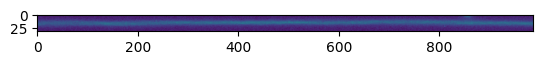

In [58]:
i = 600
# print(targets.iloc[i])
# print()
# print(numeric.iloc[i])
print(len(numeric))
print(len(targets))
print(len(images))
plt.imshow(images[i])
plt.show()


In [25]:

maxs = []
mins = []
medians = []
means = []
stds = []
widths = []
for i in range(1, 5001):
    
    with fits.open(utils.path_from_proot(f'data/dataset_for_student/image_{i:05}.fits')) as hdul:
        # print(hdul[0].header)
        img = np.array(hdul[0].data)
        # Print max, min, median, mean, std, ...
        # print(f"Max: {img.max()}, Min: {img.min()}, Median: {np.median(img)}, Mean: {img.mean()}, Std: {img.std()}, Shape: {img.shape}")
        maxs.append(img.max())
        mins.append(img.min())
        medians.append(np.median(img))
        means.append(img.mean())
        stds.append(img.std())
        widths.append(img.shape[0])

# print statistics on the statistics
# Max statistics
print(f"Max: Max: {max(maxs)}, Min: {min(maxs)}, Median: {np.median(maxs)}, Mean: {np.mean(maxs)}, Std: {np.std(maxs)}")
# Min statistics
print(f"Min: Max: {max(mins)}, Min: {min(mins)}, Median: {np.median(mins)}, Mean: {np.mean(mins)}, Std: {np.std(mins)}")
# Median statistics
print(f"Median: Max: {max(medians)}, Min: {min(medians)}, Median: {np.median(medians)}, Mean: {np.mean(medians)}, Std: {np.std(medians)}")
# Mean statistics
print(f"Mean: Max: {max(means)}, Min: {min(means)}, Median: {np.median(means)}, Mean: {np.mean(means)}, Std: {np.std(means)}")
# Std statistics
print(f"Std: Max: {max(stds)}, Min: {min(stds)}, Median: {np.median(stds)}, Mean: {np.mean(stds)}, Std: {np.std(stds)}")

# Width statistics
print(f"Width: Max: {max(widths)}, Min: {min(widths)}, Median: {np.median(widths)}, Mean: {np.mean(widths)}, Std: {np.std(widths)}")

Max: Max: 2127, Min: 1450, Median: 1727.0, Mean: 1724.1804, Std: 86.80481931229394
Min: Max: 68, Min: 44, Median: 61.0, Mean: 60.9796, Std: 3.138850719610603
Median: Max: 143.0, Min: 142.0, Median: 142.0, Mean: 142.0705, Std: 0.2545186633628269
Mean: Max: 276.44114, Min: 275.38356, Median: 275.93853, Mean: 275.937432668, Std: 0.1395583379468309
Std: Max: 302.21667811470564, Min: 296.92222354991145, Median: 299.51787576489903, Mean: 299.5800295264284, Std: 1.0558987960867168
Width: Max: 1000, Min: 1000, Median: 1000.0, Mean: 1000.0, Std: 0.0


In [23]:

for i in range(1, 5001):
# for i in range(1, 2):

    with fits.open(utils.path_from_proot(f'data/dataset_for_student/image_{i:05}.fits')) as hdul:
        # print(hdul[0].header)
        img = np.array(hdul[0].data).transpose()
        np.save(utils.path_from_proot(f'src/datasets/synthetic_32/image_{i:05}.npy'), img[9:-9])



In [5]:
synthetic32_df = pd.read_csv(utils.path_from_proot('src/datasets/synthetic_32.csv'))
synthetic32_df['npy_path'] = synthetic32_df['image_name'].apply(lambda img_name: img_name[:-4] + 'npy')
synthetic32_df.to_csv(utils.path_from_proot('src/datasets/synthetic_32.csv'))

In [4]:

for i in range(1, 5001):
    # for i in range(1, 2):

    with fits.open(utils.path_from_proot(f'data/dataset_for_student/image_{i:05}.fits')) as hdul:
        # print(hdul[0].header)
        img = np.array(hdul[0].data).transpose()
        np.save(utils.path_from_proot(f'src/datasets/synthetic_50/image_{i:05}.npy'), img)


In [6]:
import torch
import torch.nn as nn

# Create a simple input tensor with shape (batch=1, channels=1, height=4, width=4)
# For clarity, let's make it something easy to visualize
input_tensor = torch.arange(16, dtype=torch.float).view(1, 1, 4, 4)
print("Original Tensor:")
print(input_tensor)

# Define a vertical MaxPool layer
# kernel_size=(2,1) pools 2 rows at a time, leaving columns untouched
vertical_pool = nn.MaxPool2d(kernel_size=(1, 2))

# Apply vertical max pooling
pooled_tensor = vertical_pool(input_tensor)
print("\nPooled Tensor:")
print(pooled_tensor)

Original Tensor:
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Pooled Tensor:
tensor([[[[ 1.,  3.],
          [ 5.,  7.],
          [ 9., 11.],
          [13., 15.]]]])


In [40]:
from src import utils
import pandas as pd
import os
streaks = pd.read_csv(os.path.join(utils.get_project_root(), "src/datasets/combined_lc.csv"))
print(len(streaks["file_name"].unique()))
good = pd.read_csv(os.path.join(utils.get_project_root(), "good_data_lc.csv"))
good_file_name = good["file_name"].unique()
print(len(good["file_name"].unique()))
# print good columns
print(good.columns)
combined = pd.read_csv(os.path.join(utils.get_project_root(), "combined_streaks.csv"))
print(len(combined["file_name"].unique()))
print(len(combined[combined["file_name"].isin(good["file_name"].unique())]["norad_number"].isnull()))


213
213
Index(['Unnamed: 0', 'file_name', 'extension', 'ID', 'x_start[px]',
       'y_start[px]', 'x_end[px]', 'y_end[px]', 'ang_vel[deg/s]', 'width'],
      dtype='object')
245
1065


In [43]:
from astropy.io import fits
file_name = "OMEGA.2022-01-12T02:17:31.769.astred.cal.fits"
with fits.open(utils.get_fits_path(file_name, False)) as hdul:
    print(hdul[8].data.shape)

    #4100x2048
# visualize image
# utils.highlight_fits(file_name)

(4200, 2144)


In [51]:
from astropy.io import fits
file_name = "OMEGA.2022-01-12T02:17:31.769.astred.cal.fits"
with fits.open(utils.get_fits_path(file_name, False)) as hdul:
    for head in   hdul[0].header:
        print(head + ":", hdul[0].header[head])


SIMPLE: True
BITPIX: 16
NAXIS: 0
EXTEND: True
ORIGIN: ESO-PARANAL
DATE: 2023-11-03T10:03:08
TELESCOP: ESO-VST
INSTRUME: OMEGACAM
OBJECT: J0659+1629
RA: 104.816958
DEC: 16.60979
EQUINOX: 2000.0
RADECSYS: FK5
EXPTIME: 320.0
MJD-OBS: 59591.095506581
DATE-OBS: 2022-01-12T02:17:31.768
UTC: 8244.0
LST: 18122.273
PI-COI: UNKNOWN
OBSERVER: UNKNOWN
ESO ADA ABSROT END: 34.29889
ESO ADA ABSROT PPOS: POS
ESO ADA ABSROT START: 35.59825
ESO ADA GUID STATUS: OFF
ESO ADA POSANG: 0.0
ESO DET BITS: 16
ESO DET CHIPS: 32
ESO DET DATE: 2004-11-10
ESO DET DEC: 0.0
ESO DET DID: ESO-VLT-DIC.OMEGA_CCD,ESO-VLT-DIC.FCDDCS
ESO DET EXP NO: 391
ESO DET EXP RDTTIME: 30.625
ESO DET EXP TYPE: Normal
ESO DET EXP XFERTIM: 30.556
ESO DET FRAM ID: 1
ESO DET FRAM TYPE: Normal
ESO DET ID: CCD FIERA - Rev: 238334
ESO DET NAME: ocmsci1 - ocmsci1
ESO DET OUTPUTS: 32
ESO DET OUTREF: 0
ESO DET RA: 0.0
ESO DET READ CLOCK: mosaic read (ordered)
ESO DET READ MODE: normal
ESO DET READ NFRAM: 1
ESO DET READ SPEED: normal
ESO DET SHUT